In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical
from pypfopt.efficient_frontier import EfficientFrontier


'1.19.2'

In [2]:
tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')

In [3]:
def get_weights(r0, mean, std, covar):
   
    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = len(mean)
    mean = mean.values.reshape((n,1))
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((n, 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

In [60]:
days = 20
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]:
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    r0 = mean.median()
    r0s.append([r0])
    std = sample.std(axis=0)
    covar = sample.cov()
    weights_vector = get_weights(r0, mean, std, covar)
    portfolio = pd.concat([stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector), portfolio])
    saved_weights.append(weights_vector.flatten())
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)


In [62]:
n = len(tickers)
equal_weights = stocks.dot(np.ones((n,1))/n)

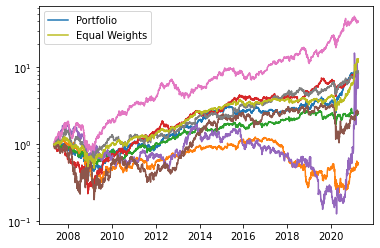

In [63]:

plt.plot((1+portfolio).cumprod(), label = 'Portfolio')
plt.plot((1+stocks).cumprod())
plt.plot((1+equal_weights).cumprod(), label = 'Equal Weights')
plt.yscale("log")
plt.legend()

In [65]:
empyrical.sharpe_ratio(stocks).max()

0.9771675736061394

In [66]:
empyrical.sharpe_ratio(equal_weights)

array([0.81624048])

In [67]:
empyrical.sharpe_ratio(portfolio)


array([0.68083264])

# Notes 
1. Median, Window_Size = 20, Tickers = ["GE", "PFE", "Starbucks], Sharpe:0.75383353 vs. 0.7161903905293208
2. Median, Window_Size = 20, Tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ], Sharpe:  .68083264 vs .81624048

In [1]:
!pip install PyPortfolioOpt

  Using cached PyPortfolioOpt-1.4.1-py3-none-any.whl (56 kB)
  Using cached cvxpy-1.1.11-cp37-cp37m-win_amd64.whl (819 kB)
  Using cached ecos-2.0.7.post1.tar.gz (126 kB)
  Using cached osqp-0.6.2.post0-cp37-cp37m-win_amd64.whl (162 kB)
  Using cached scs-2.1.2.tar.gz (3.5 MB)
  Using cached qdldl-0.1.5.post0-cp37-cp37m-win_amd64.whl (75 kB)
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp37-cp37m-win_amd64.whl size=68301 sha256=c9e2c1480f5fda0c0e6eaad3a9124aa52f1e51c086915d0026b774dfee9cdf0c
  Stored in directory: c:\users\work\appdata\local\pip\cache\wheels\70\e7\fd\4a4f957fc18a0f0407ca4b331c51e6a469c92efec58f732edf
  Created wheel for scs: filename=scs-2.1.2-cp37-cp37m-win_amd64.whl size=119528 sha256=72b46d123d1ba25050a823db22638c5a595233dd75dd6af38ee4b8ce55a04247
  Stored in directory: c:\users\work\appdata\local\pip\cache\wheels\bc\e9\2d\41c52bfaefbbbee5b3c6c189e168039f6ac9b40fa2e14fe96d
Successfully built ecos scs


In [7]:
mu = stocks.mean()
sigma = stocks.cov()


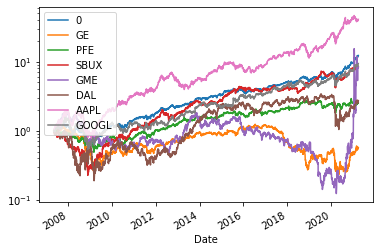

In [29]:
Ef = EfficientFrontier(mu, sigma)
weight_vector = Ef.efficient_return(mu.median())
weight_list = [weight_vector[ticker] for ticker in stocks.columns]
portfolio = stocks.dot(weight_list)
dataframe = pd.concat([portfolio, stocks], axis=1)
(1 + dataframe).cumprod().plot()
plt.yscale("log")

In [30]:
empyrical.sharpe_ratio(dataframe)

array([0.93553408, 0.06833444, 0.40368583, 0.64163664, 0.55045152,
       0.40458446, 0.98206662, 0.69236649])

In [24]:
empyrical.sharpe_ratio(portfolio)

0.9813931534812828

In [25]:
weight_vector

OrderedDict([('GE', 0.0),
             ('PFE', 0.3263435408843372),
             ('SBUX', 0.1357710173820539),
             ('GME', 0.0551322450341867),
             ('DAL', 0.0),
             ('AAPL', 0.3294795757218001),
             ('GOOGL', 0.1532736209776221)])

In [10]:
days = 20
sampled_means = stocks.resample(str(days)+"d").mean()
sampled_covars = [sample[1].cov() for sample in stocks.resample(str(days)+"d")]

In [16]:
weight_dicts = [EfficientFrontier(mean,cov).min_volatility() for mean, cov in zip(sampled_means.values,sampled_covars)]

In [101]:
days = 5
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]: 
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    covar = sample.cov()
    weights_vector = [EfficientFrontier(mean,covar).max_quadratic_utility()[ticker] for ticker in stocks.columns]
    portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
    saved_weights.append(weights_vector)
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)

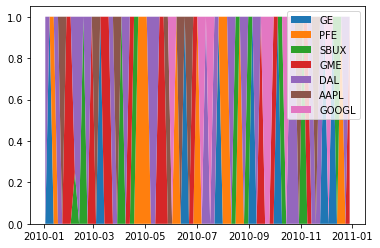

In [105]:
plt.stackplot(saved_weights['2010':'2010'].index, *(saved_weights[ticker]['2010':'2010'] for ticker in saved_weights.columns), labels=saved_weights.columns)
plt.legend()

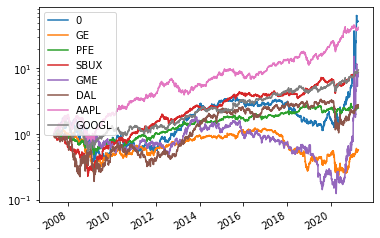

In [103]:
(1+pd.concat([portfolio,stocks],axis=1)).cumprod().plot()
plt.yscale('log')

In [104]:
empyrical.sharpe_ratio(pd.concat([portfolio,stocks],axis=1))

array([0.68865798, 0.06815994, 0.40073232, 0.64541186, 0.5426178 ,
       0.40327657, 0.98922867, 0.69547319])

In [94]:
saved_weights.sum(axis=1).max()

1.0000139551820657

In [62]:
def Mean_Variance_Rolling(days):
    X = stocks.resample(str(days)+"d").mean()
    dates = X.index[1:-1]
    portfolio = pd.DataFrame()

    saved_weights = []
    r0s = []

    for day in dates[:-1]:
        #sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
        sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

        mean = sample.mean(axis=0)
        covar = sample.cov()
        weights_vector = [EfficientFrontier(mean,covar).min_volatility()[ticker] for ticker in stocks.columns]
        portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
        saved_weights.append(weights_vector)
    portfolio = portfolio.sort_index()
    saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)
    return portfolio


array([0.54052055])

In [49]:
sharpe_ratios

[]